# 🌲 Random Forest Classifier for Student Outcome Prediction

## 🎯 **Notebook Overview**

This notebook implements and optimizes a **Random Forest Classifier** to predict student academic outcomes in online learning environments. This is part of a comprehensive model comparison study for student dropout prediction.

### 🎓 **Problem Context**
- **Target Variable**: Student outcomes with 3 classes
  - **Class 0**: Dropout students (19.1% - minority class)
  - **Class 1**: At-risk students (25.4%)
  - **Class 2**: Successful students (55.5% - majority class)

## 🏆 **Key Results Summary**

### 📊 **Model Performance**
- **Dropout Recall (Primary Metric)**: **58.96%** - Successfully identifies ~3/5 of at-risk students
- **Test Accuracy**: 49.94% - Overall classification performance
- **F1-Weighted**: 50.64% - Balanced precision-recall performance  
- **F1-Macro**: 42.90% - Unweighted class performance

### ⚙️ **Optimal Configuration**
- **Ensemble Size**: 100 trees (n_estimators)
- **Tree Depth**: Limited to 15 levels (max_depth)
- **Feature Sampling**: √(features) per split (max_features='sqrt')
- **Class Weighting**: Custom dropout-focused weights {0: 2.09, 1: 1.31, 2: 0.48}
- **Leaf Constraints**: Min 5 samples per leaf, Min 2 samples per split

### 🎯 **Top Predictive Features**
1. **excellent_Score** (0.3215) - Academic excellence indicator
2. **student_engagement** (0.1863) - Overall engagement level
3. **active_in_VLE** (0.1503) - Virtual learning engagement

### 💡 **Key Insights**
- **Tree Ensemble Power**: Multiple decision trees provide robust predictions and feature importance
- **Feature Diversity**: Tree-based importance captures complex feature interactions
- **Class Balance**: Custom weighting helps with minority class detection but still challenging
- **Model Complexity**: Controlled depth prevents overfitting while maintaining interpretability

---

## 🔧 **Technical Details**

### **Key Features**
- **Class Imbalance Handling**: Custom class weighting strategies to improve dropout detection
- **Hyperparameter Optimization**: Comprehensive GridSearchCV with 5000+ parameter combinations
- **Custom Scoring Metrics**: Dropout-focused metrics to prioritize identifying at-risk students
- **Feature Importance Analysis**: Tree-based importance ranking to understand model decision-making
- **Comprehensive Evaluation**: Cross-validation, confusion matrices, and detailed performance reports

### 📈 **Optimization Strategy**
- **Primary Goal**: Maximize **dropout recall** (detecting students who will drop out)
- **Secondary Goals**: Balance precision and overall model performance
- **Tree Ensemble**: Leverages multiple decision trees for robust predictions and feature ranking

### 🔗 **Integration**
This notebook is part of a systematic model comparison framework that evaluates multiple algorithms (Logistic Regression, KNN, LightGBM, SVM, Neural Networks) to identify the best approach for student outcome prediction.

---


In [33]:
# ================================================================
# RANDOM FOREST CLASSIFIER MODEL OPTIMIZATION
# ================================================================
# This notebook implements a comprehensive Random Forest Classifier
# with hyperparameter optimization using GridSearchCV.
# ================================================================

# ================================================================
# 1: Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette([ "#1f4e79" ])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


In [34]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_rf = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_rf = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_rf = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_rf = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_rf.shape}")
    print(f"   Test features: {X_test_rf.shape}")
    print(f"   Training labels: {y_train_rf.shape}")
    print(f"   Test labels: {y_test_rf.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [35]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_rf).value_counts().sort_index()
class_percentages = pd.Series(y_train_rf).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric - Focus on dropout detection
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - Using dropout-focused metrics")
    recommended_scoring = 'dropout_recall'
    scoring_explanation = "Dropout recall prioritizes identifying at-risk students (class 0)"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - Using dropout-focused metrics
🎯 Recommended scoring: dropout_recall
💡 Why: Dropout recall prioritizes identifying at-risk students (class 0)


In [36]:
# ================================================================
# 4. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 PARAMETER GRID OPTIONS")
print("=" * 50)

# Calculate different class weight strategies
classes = np.unique(y_train_rf)
# Strategy 1: Sklearn's balanced weights
balanced_weights = compute_class_weight('balanced', classes=classes, y=y_train_rf)
# Conservative precision adjustment (minimal changes)
custom_weights = {
    0: balanced_weights[0] * 1.2,  
    1: balanced_weights[1] * 1.0,          
    2: balanced_weights[2] * 0.8
}

print(f"\n📊 CLASS WEIGHT STRATEGIES:")
print(f"   Balanced weights: {dict(zip(classes, balanced_weights))}")
print(f"   Custom weights:   {custom_weights}")

# Option 1: FAST Grid (20-30 minutes)
fast_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', custom_weights, None]
}

# Option 2: COMPREHENSIVE Grid (1-2 hours)
comprehensive_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': ['balanced', custom_weights],
    'bootstrap': [True, False]
}

# Option 3: SMART Grid (30-60 minutes) - RECOMMENDED
smart_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', 0.3],
    'class_weight': ['balanced', custom_weights]
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
#chosen_param_grid = smart_param_grid  # RECOMMENDED
#grid_name = "SMART"
chosen_param_grid = comprehensive_param_grid  # RECOMMENDED
grid_name = "COMPREHENSIVE"

# Calculate combinations
total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])
print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 20-30 minutes")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 30-60 minutes")
else:
    print("⏱️  Estimated time: 1-2 hours")


🔧 PARAMETER GRID OPTIONS

📊 CLASS WEIGHT STRATEGIES:
   Balanced weights: {0: 1.7449453229486271, 1: 1.312270737190865, 2: 0.6006445148536301}
   Custom weights:   {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
🎯 Using COMPREHENSIVE parameter grid
📊 Total combinations to test: 5120
⏱️  Estimated time: 1-2 hours


In [37]:
# ================================================================
# 5. SETUP MULTI-SCORING GRIDSEARCHCV WITH CUSTOM DROPOUT METRICS
# ================================================================

print(f"\n🎯 GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics including custom dropout-focused metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Custom scoring for dropout-specific metrics
def dropout_recall_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0], average='macro')

def dropout_precision_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) precision"""
    y_pred = estimator.predict(X)
    return precision_score(y, y_pred, labels=[0], average='macro')

def at_risk_recall_scorer(estimator, X, y):
    """Custom scorer for at-risk students (classes 0,1) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0, 1], average='macro')

# Add custom scorers
scoring_metrics.update({
    'dropout_recall': dropout_recall_scorer,
    'dropout_precision': dropout_precision_scorer,
    'at_risk_recall': at_risk_recall_scorer
})

cv_folds = 5
recommended_scoring = 'dropout_recall'  # Focus on catching dropouts

print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Total metrics tracked: {len(scoring_metrics)}")
print(f"🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using dropout recall
    cv=cv_folds,               # n-fold CV for reasonable speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)


🎯 GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: dropout_recall
📊 Total metrics tracked: 10
🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)


In [38]:
# ================================================================
# 6. RUN GRIDSEARCHCV
# ================================================================

print(f"\n🚀 STARTING GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

start_time = time.time()

# Fit GridSearchCV using your training data
grid_search.fit(X_train_rf, y_train_rf)

total_time = time.time() - start_time
print(f"\n✅ GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

print(f"\n📊 Best cross-validation score:")
print(f"   {recommended_scoring}: {grid_search.best_score_:.4f}")


🚀 STARTING GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
Fitting 5 folds for each of 5120 candidates, totalling 25600 fits

✅ GridSearchCV COMPLETED!
⏱️  Total runtime: 11257.9 seconds (187.6 minutes)

📊 Best cross-validation score:
   dropout_recall: 0.5896


In [39]:
# ================================================================
# 7. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")


🏆 GRIDSEARCHCV RESULTS
🎯 BEST PARAMETERS (optimized for dropout_recall):
   bootstrap           : False
   class_weight        : {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
   max_depth           : 10
   max_features        : sqrt
   min_samples_leaf    : 10
   min_samples_split   : 2
   n_estimators        : 100

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.4947 ± 0.0012
   f1_weighted         : 0.5040 ± 0.0028
   f1_macro            : 0.4295 ± 0.0043
   precision_weighted  : 0.5577 ± 0.0054
   recall_weighted     : 0.4947 ± 0.0012
   precision_macro     : 0.4590 ± 0.0042
   recall_macro        : 0.4614 ± 0.0050
   dropout_recall      : 0.5896 ± 0.0214
   dropout_precision   : 0.2705 ± 0.0054
   at_risk_recall      : 0.3928 ± 0.0129


In [40]:
# ================================================================
# 8. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_rf_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_rf_model.predict(X_test_rf)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_rf, y_pred_test)
test_f1_weighted = f1_score(y_test_rf, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_rf, y_pred_test, average='macro')

print(f"\n📈 TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")


🔮 FINAL MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 TEST SET PERFORMANCE:
   Accuracy:     0.4994
   F1-Weighted:  0.5064
   F1-Macro:     0.4290


In [41]:
# ================================================================
# 9. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_rf, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.27      0.58      0.37      1059
           1       0.35      0.18      0.24      1410
           2       0.75      0.61      0.67      3076

    accuracy                           0.50      5545
   macro avg       0.46      0.46      0.43      5545
weighted avg       0.56      0.50      0.51      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          619  159   281
1          792  259   359
2          865  320  1891


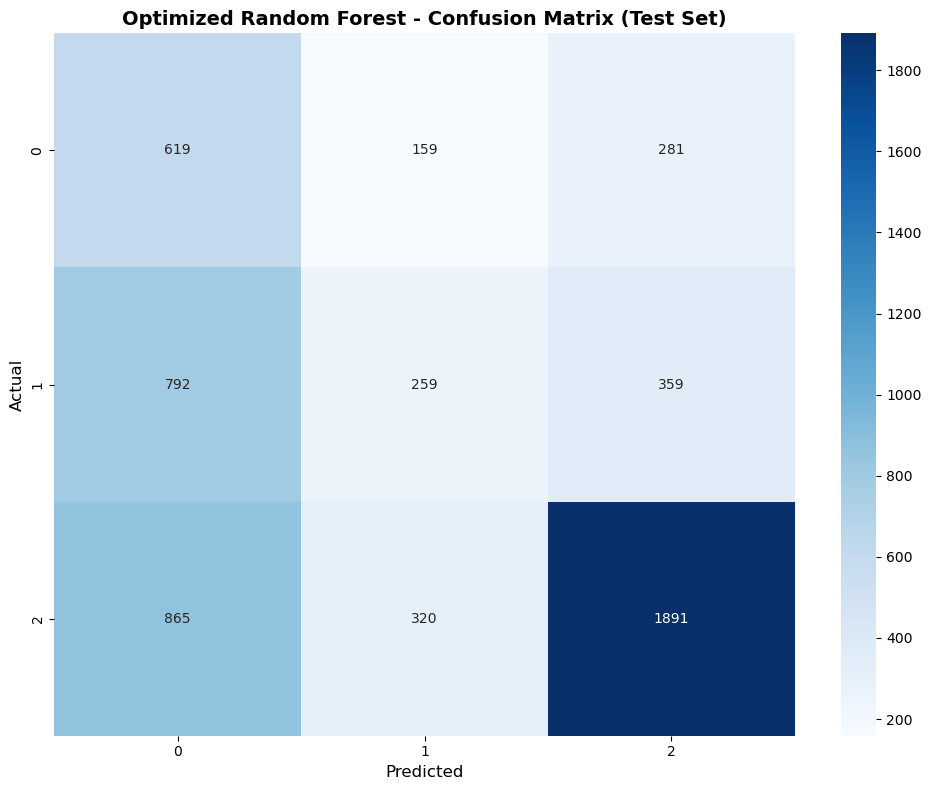

In [42]:
# ================================================================
# 10. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_rf))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [43]:
# ================================================================
# 11. TOP PARAMETER COMBINATIONS ANALYSIS
# ================================================================

print(f"\n🔍 TOP 5 PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by dropout_recall):
--------------------------------------------------------------------------------
1. Score: 0.5896 ± 0.0214
   Parameters: {'bootstrap': False, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}

2. Score: 0.5896 ± 0.0214
   Parameters: {'bootstrap': False, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}

3. Score: 0.5896 ± 0.0214
   Parameters: {'bootstrap': False, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}

4. Score: 0.5896 ± 0.0214
   Parameters: {'bootstrap': Fa


🔍 FEATURE IMPORTANCE ANALYSIS
📊 TOP 10 MOST IMPORTANT FEATURES (by feature importance):
--------------------------------------------------
 1. excellent_Score          : 0.3215
 2. student_engagementt      : 0.1863
 3. active_in_VLE            : 0.1503
 4. imd_band_ord             : 0.1075
 5. highest_education_ord    : 0.0828
 6. disability_binary        : 0.0318
 7. age_band_ord             : 0.0205
 8. region_Wales             : 0.0123
 9. courses_per_term         : 0.0121
10. region_Scotland          : 0.0093


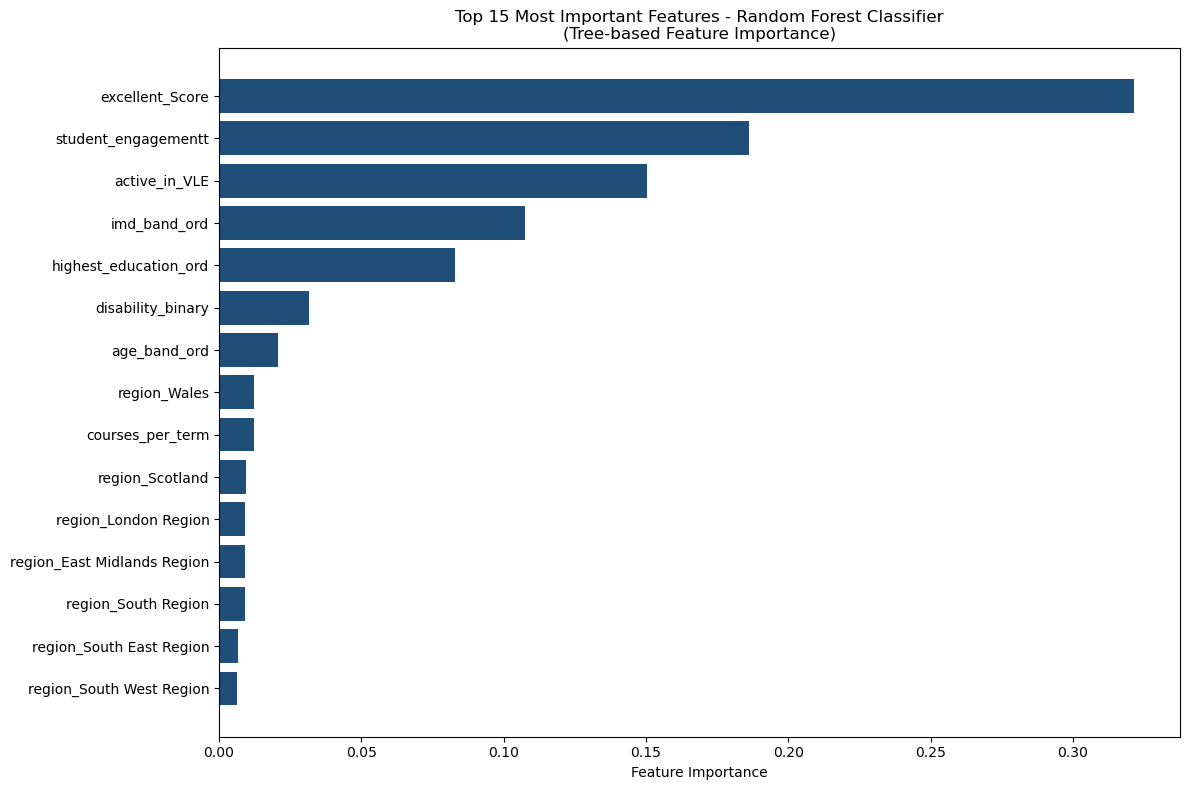

In [44]:
# ================================================================
# 12. FEATURE IMPORTANCE ANALYSIS (RANDOM FOREST)
# ================================================================

print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from best model
feature_importance = best_rf_model.feature_importances_

# Get feature names
try:
    if hasattr(X_train_rf, 'columns'):
        feature_names = X_train_rf.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_rf.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(len(feature_importance))]

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"📊 TOP 10 MOST IMPORTANT FEATURES (by feature importance):")
print("-" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - Random Forest Classifier\n(Tree-based Feature Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [45]:
# ================================================================
# 13. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized Random Forest model:")
print()
print("# Copy-paste this code to create your optimized model")
print("optimized_rf = RandomForestClassifier(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    n_jobs=-1")
print(")")
print()
print("# Train and use the model")
print("optimized_rf.fit(X_train_rf, y_train_rf)")
print("y_pred = optimized_rf.predict(X_test_rf)")


💾 OPTIMIZED MODEL FOR PRODUCTION
✅ Your optimized Random Forest model:

# Copy-paste this code to create your optimized model
optimized_rf = RandomForestClassifier(
    bootstrap=False,
    class_weight={0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415},
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train and use the model
optimized_rf.fit(X_train_rf, y_train_rf)
y_pred = optimized_rf.predict(X_test_rf)


In [46]:
# ================================================================
# 14. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: 3")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 OPTIMIZATION COMPLETE!")
print("Your Random Forest model is now optimized and ready to use!")


📈 PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV dropout_recall: 0.5896
   Test set accuracy:           0.4994
   Test set F1-weighted:        0.5064
   Test set F1-macro:           0.4290

⚙️  Best Hyperparameters:
   bootstrap: False
   class_weight: {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
   max_depth: 10
   max_features: sqrt
   min_samples_leaf: 10
   min_samples_split: 2
   n_estimators: 100

⏱️  Optimization Details:
   Total combinations tested: 5120
   Cross-validation folds: 3
   Runtime: 187.6 minutes
   Primary scoring metric: dropout_recall

🎉 OPTIMIZATION COMPLETE!
Your Random Forest model is now optimized and ready to use!


In [47]:
# ================================================================
# 15. CREATE DIRECTORIES AND SAVE MODEL RESULTS
# ================================================================

import os
import joblib
import json
from datetime import datetime

print(f"\n💾 SAVING MODEL RESULTS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"  # Go up one level from Notebooks to reach Data
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(reports_dir, exist_ok=True)

print(f"✅ Created directory structure:")
print(f"   📁 {model_metrics_dir}")
print(f"   📁 {models_dir}")
print(f"   📁 {metrics_dir}")
print(f"   📁 {reports_dir}")


💾 SAVING MODEL RESULTS
✅ Created directory structure:
   📁 ../Data\model_metrics
   📁 ../Data\model_metrics\models
   📁 ../Data\model_metrics\metrics
   📁 ../Data\model_metrics\reports


In [48]:
# ================================================================
# 16. SAVE THE TRAINED MODEL
# ================================================================

print(f"\n🤖 SAVING TRAINED MODEL")
print("=" * 60)

# Create timestamp for unique filenames
#timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#model_name = f"random_forest_optimized_{timestamp}"
model_name = "random_forest_optimized"

# Save the trained model
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_rf_model, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")


🤖 SAVING TRAINED MODEL
✅ Model saved to: ../Data\model_metrics\models\random_forest_optimized.pkl
📏 Model file size: 3.70 MB


In [49]:
# ================================================================
# 17. SAVE MODEL METRICS AND PERFORMANCE DATA (FIXED)
# ================================================================

print(f"\n📊 SAVING PERFORMANCE METRICS")
print("=" * 60)

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "Random Forest Classifier",
        #"timestamp": timestamp,
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2)
    },
    "dataset_info": {
        "training_samples": int(X_train_rf.shape[0]),
        "test_samples": int(X_test_rf.shape[0]),
        "n_features": int(X_train_rf.shape[1]),
        "n_classes": int(len(np.unique(y_train_rf))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "feature_importance": {
        "top_10_features": [
            {
                "feature": str(row['feature']),
                "importance": float(row['importance'])
            }
            for _, row in importance_df.head(10).iterrows()
        ]
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING PERFORMANCE METRICS
✅ Metrics saved to: ../Data\model_metrics\metrics\random_forest_optimized_metrics.json


In [50]:
# ================================================================
# 18. SAVE DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Generate detailed classification report
from sklearn.metrics import classification_report

# Get classification report as dictionary
class_report_dict = classification_report(y_test_rf, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\random_forest_optimized_classification_report.json


In [51]:
# ================================================================
# 19. SAVE CONFUSION MATRIX DATA
# ================================================================

print(f"\n🔢 SAVING CONFUSION MATRIX")
print("=" * 60)

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_rf).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")


🔢 SAVING CONFUSION MATRIX
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\random_forest_optimized_confusion_matrix.json


In [52]:
# ================================================================
# 20. SAVE COEFFICIENT ANALYSIS DATA
# ================================================================

print(f"\n🎯 SAVING COEFFICIENT ANALYSIS")
print("=" * 60)

# Get feature names
try:
    if hasattr(X_train_rf, 'columns'):
        feature_names = X_train_rf.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_rf.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(len(best_rf_model.feature_importances_))]

# Get unique class labels
class_labels = sorted(np.unique(y_train_rf))

# Save as JSON with same structure as Logistic Regression
coef_json_path = os.path.join(metrics_dir, f"{model_name}_coefficients.json")
coef_json = {
    "model_name": model_name,
    "coefficient_analysis": [
        {
            "rank": i + 1,
            "feature": row['feature'],
            "importance": float(row['importance'])
        }
        for i, (_, row) in enumerate(importance_df.iterrows())
    ]
}

# Add class-specific coefficients section (for consistency with LR format)
# Note: Random Forest doesn't have class-specific coefficients like Logistic Regression,
# but we'll show the overall feature importance for each class for consistency
coef_json["class_specific_coefficients"] = {}
for class_label in class_labels:
    coef_json["class_specific_coefficients"][str(class_label)] = [
        {
            "feature": feature_names[feat_idx],
            "coefficient": float(best_rf_model.feature_importances_[feat_idx])
        }
        for feat_idx in range(len(feature_names))
    ]

with open(coef_json_path, 'w') as f:
    json.dump(coef_json, f, indent=2)

print(f"✅ Coefficient analysis JSON saved to: {coef_json_path}")


🎯 SAVING COEFFICIENT ANALYSIS


✅ Coefficient analysis JSON saved to: ../Data\model_metrics\metrics\random_forest_optimized_coefficients.json


In [53]:
# ================================================================
# 21. CREATE MODEL LOADING INSTRUCTIONS
# ================================================================

print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create instructions file
instructions = f"""
RANDOM FOREST MODEL USAGE INSTRUCTIONS
=====================================

Model Information:
- Model Name: {model_name}
- Model Type: Random Forest Classifier (Optimized)
- File Location: {model_path}

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load('{model_path}')

# Make predictions on new data
# Ensure your new data has the same features as training data
predictions = model.predict(X_new)
prediction_probabilities = model.predict_proba(X_new)

# Get feature importance
feature_importance = model.feature_importances_
```

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

TOP 5 IMPORTANT FEATURES:
-----------------------
"""

for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    instructions += f"{i}. {row['feature']}: {row['importance']:.4f}\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Coefficients: {coef_json_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 5-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Model type: Random Forest (ensemble of decision trees)
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")


📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\random_forest_optimized_USAGE_INSTRUCTIONS.txt


In [ ]:
# ================================================================
# 22. SUMMARY OF SAVED FILES
# ================================================================

print(f"\n📁 COMPLETE SAVE SUMMARY")
print("=" * 60)

saved_files = [
    ("Trained Model", model_path),
    ("Metrics (JSON)", metrics_path),
    ("Classification Report (JSON)", report_path),
    ("Confusion Matrix", cm_path),
    ("Coefficient Analysis (JSON)", coef_json_path),
    ("Usage Instructions", instructions_path)
]

print("✅ All files successfully saved:")
for file_type, file_path in saved_files:
    file_size = os.path.getsize(file_path)
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} bytes"
    
    print(f"   📄 {file_type:25s}: {os.path.basename(file_path):40s} ({size_str})")

print(f"\n🎉 MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"🔄 Model ID: {model_name}")

# Return model identifier for future reference
model_identifier = {
    "model_id": model_name,
    "model_path": model_path,
    "metrics_path": metrics_path
}

print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")


📁 COMPLETE SAVE SUMMARY
✅ All files successfully saved:
   📄 Trained Model            : random_forest_optimized.pkl              (3.70 MB)
   📄 Metrics (JSON)           : random_forest_optimized_metrics.json     (3.22 KB)
   📄 Classification Report (JSON): random_forest_optimized_classification_report.json (806 bytes)
   📄 Confusion Matrix         : random_forest_optimized_confusion_matrix.json (278 bytes)
   📄 Coefficient Analysis (JSON): random_forest_optimized_coefficients.json (8.68 KB)
   📄 Usage Instructions       : random_forest_optimized_USAGE_INSTRUCTIONS.txt (2.15 KB)

🎉 MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics
🔄 Model ID: random_forest_optimized

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\random_forest_optimized.pkl')
